# Credit Default Prediction – Experimental Notebook

**Objective:**  
This notebook is used for experimenting with different preprocessing, modeling, and evaluation techniques to predict the probability of credit default for the next month. The goal is to explore various strategies to improve recall and F1-score for detecting potential defaulters.

**Scope of Experiments:**  
1. Data cleaning and preprocessing  
2. Feature engineering (original vs. engineered features)  
3. Handling class imbalance (SMOTE, class weighting)  
4. Model training (Random Forest and variations)  
5. Threshold tuning to maximize recall and F1-score  
6. Evaluation using confusion matrix, classification report, and ROC-AUC  

**Note:**  
This notebook focuses on experimentation. A separate notebook will be created later for the polished, final model and results.


In [110]:
# This block imports all necessary libraries for a complete machine learning workflow.
# It includes tools for data handling, visualization, model building, and evaluation.
# The `imblearn` library is specifically included to manage potential class imbalance.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.preprocessing import FunctionTransformer

In [119]:
Credit_risk_df = pd.read_excel('default of credit card clients.xls', header = 1)
Credit_risk_df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 2. Data Exploration

In this section, we explore the dataset to understand the structure, types of features, missing values, and the distribution of the target variable.  

Key steps include:  
1. Checking dataset info (`.info()`)  
2. Previewing the first few rows (`.head()`)  
3. Examining class distribution for the target variable  
4. Identifying duplicates or anomalies in the data  
5. Visualizing basic statistics if needed


In [121]:
df = Credit_risk_df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

# Data overview

The dataset contains **30,000 entries** and **25 columns**, including demographic information, payment history, bill statements, and payment amounts. All columns are of type `int64`, and there are no missing values. 

## Column Categories

**1. Customer Information**
- `ID`: Unique identifier for each customer.
- `LIMIT_BAL`: Credit limit of the customer.
- `SEX`: Gender of the customer.
- `EDUCATION`: Education level.
- `MARRIAGE`: Marital status.
- `AGE`: Age of the customer.

**2. Payment History**
- `PAY_0` to `PAY_6`: Repayment status for the past six months (`PAY_0` is the most recent month).

**3. Bill Amounts**
- `BILL_AMT1` to `BILL_AMT6`: Statement amounts for the past six months.

**4. Payment Amounts**
- `PAY_AMT1` to `PAY_AMT6`: Actual payments made in the past six months.

**5. Target Variable**
- `default payment next month`: Indicates whether the customer will default next month (`1`) or not (`0`).

## Key Observations
- All columns have complete data with no null values.
- Numeric data types (`int64`) are consistent, which simplifies preprocessing.
- The dataset is suitable for a **binary classification task**, with `default payment next month` as the target variable.
- Memory usage is approximately **5.7 MB**.


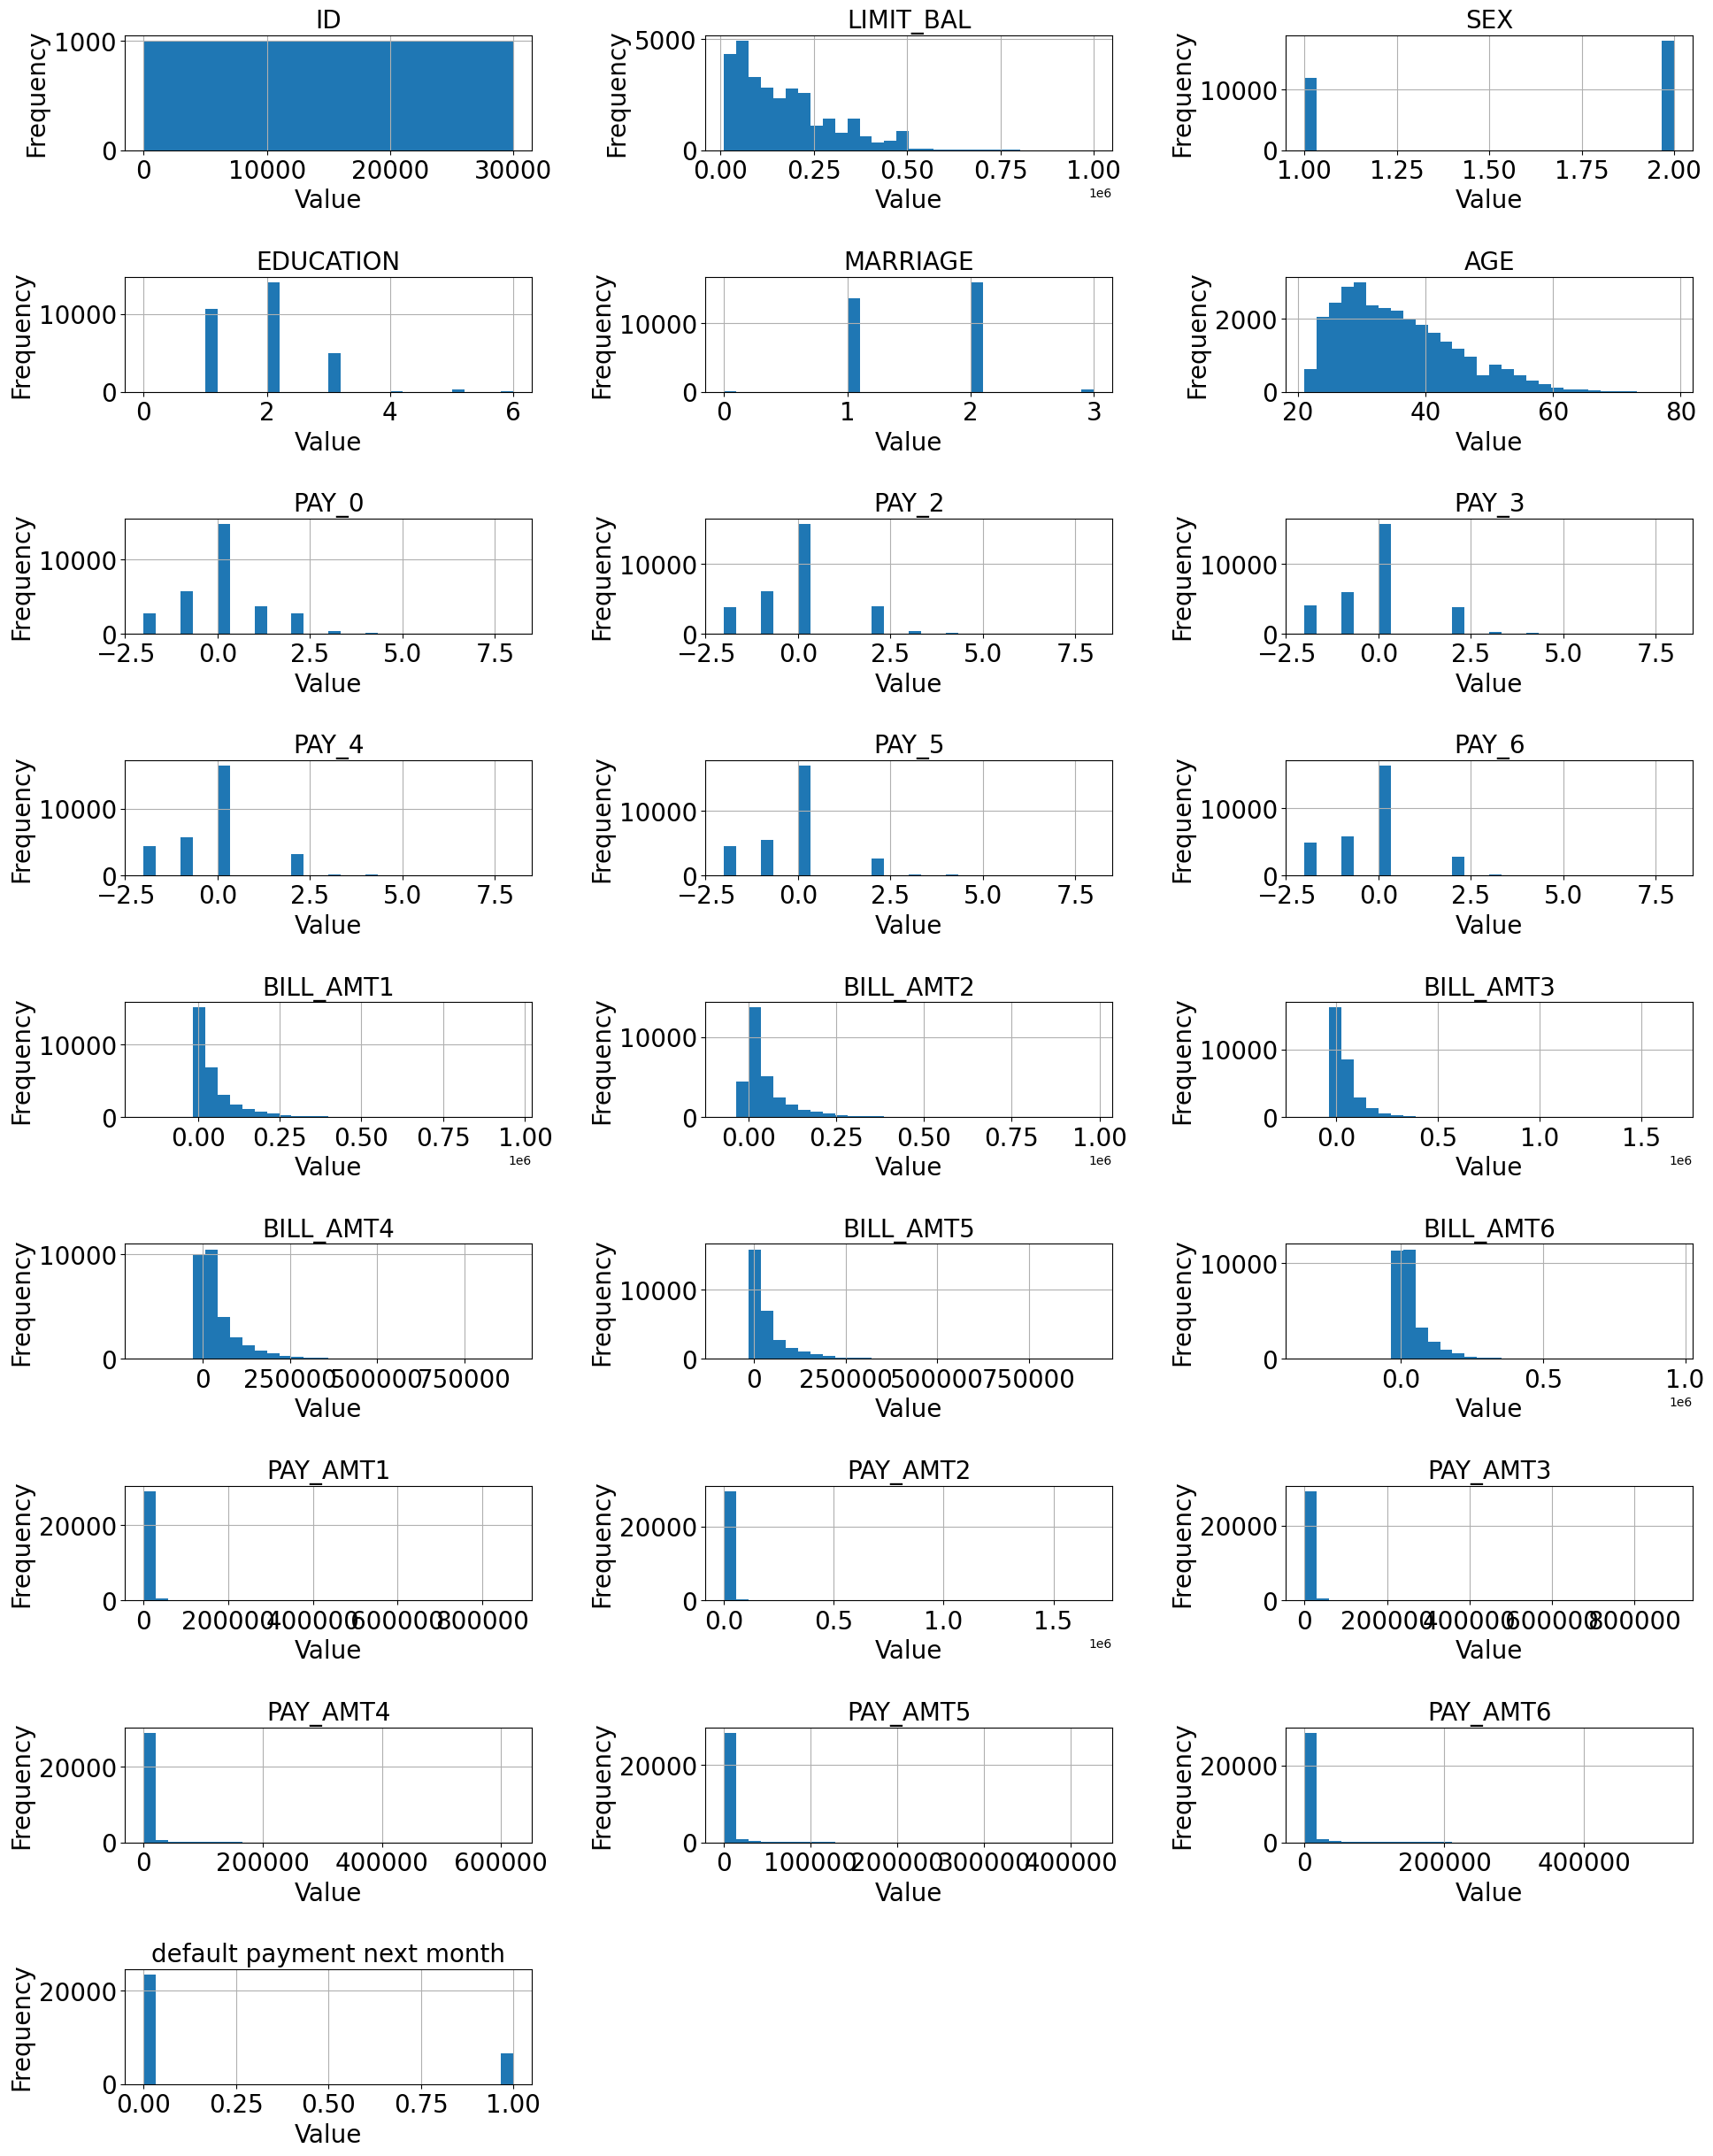

In [123]:
cols = df.columns
# Set number of columns for the subplot grid
n_cols = 3
# Calculate number of rows needed based on total columns
n_rows = (len(cols) + n_cols - 1) // n_cols

# Create subplots with specified figure size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 25))
# Flatten axes array to make it easier to iterate
axes = axes.flatten()

# Loop through each column and plot histogram
for i, col in enumerate(cols):
    df[col].hist(ax=axes[i], bins=30)  # Plot histogram with 30 bins
    axes[i].set_title(col, fontsize=20)  # Set the subplot title
    axes[i].tick_params(axis='both', which='major', labelsize=20)  # Set tick label size
    axes[i].set_xlabel('Value', fontsize=20)  # Set x-axis label
    axes[i].set_ylabel('Frequency', fontsize=20)  # Set y-axis label

# Turn off any unused axes (if total columns not divisible by n_cols)
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent overlapping of subplots
plt.tight_layout(pad=3.0)
plt.show()


# Data Distribution and Skewness

## Key Observations from Histograms

- **ID**: Unique identifier with a uniform distribution. Likely no predictive power; can be dropped or used only for indexing.

- **LIMIT_BAL**: Heavily right-skewed distribution. Most customers have lower credit limits, with a few very high limits.

- **SEX, EDUCATION, MARRIAGE**: Categorical features. Distributions are distinct across categories. For example, `SEX` shows two balanced categories (likely male and female).

- **AGE**: Approximately normal distribution, centered around 30s–40s, with a long tail for older ages.

- **PAY_0 to PAY_6**: Payment status over six months. Most customers have a value of 0 (on-time payment), but significant counts of delayed payments indicate these are critical predictors.

- **BILL_AMT1 to BILL_AMT6**: Bill amounts are heavily right-skewed. Most bills are small, but a few very high amounts exist.

- **PAY_AMT1 to PAY_AMT6**: Payment amounts also show right-skewed distributions, similar to bill amounts.

- **default payment next month**: Target variable is highly imbalanced. Most values are `0` (no default), while a minority are `1` (default). This imbalance must be addressed during modeling.

## Summary

The visualizations reveal:

1. Feature types (categorical vs numeric) and distributions.
2. Skewness in financial features (LIMIT_BAL, BILL_AMT, PAY_AMT).
3. Class imbalance in the target variable, which will impact model training.

Next steps could include:
- Handling invalid data


In [11]:
df['EDUCATION'].value_counts()

EDUCATION
2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: count, dtype: int64

## Cleaning EDUCATION Feature

The `EDUCATION` column contains some unusual values that do not correspond to standard categories:

| Value | Count |
|-------|-------|
| 0     | 14    |
| 1     | 10585 |
| 2     | 14030 |
| 3     | 4917  |
| 4     | 123   |
| 5     | 280   |
| 6     | 51    |

- Standard categories are assumed to be 1 (graduate school), 2 (university), 3 (high school), and 4 (others/unknown).
- Values 0, 5, 6 are rare and considered invalid. They are recoded into category `4` (Other/Unknown) for consistency.


In [13]:
# Recode EDUCATION
df['EDUCATION'] = df['EDUCATION'].replace({0:4, 5:4, 6:4})

# Now 4 = "Others"
df['EDUCATION'].value_counts()

EDUCATION
2    14030
1    10585
3     4917
4      468
Name: count, dtype: int64

In [ ]:
# Check the distribution of values in the 'MARRIAGE' column 
# (helps to understand class balance or detect unusual categories)
df['MARRIAGE'].value_counts()

df['MARRIAGE'].value_counts()

MARRIAGE
2    15964
1    13659
3      323
0       54
Name: count, dtype: int64

## Cleaning MARRIAGE Feature

The `MARRIAGE` column contains some unusual values:

| Value | Count |
|-------|-------|
| 0     | 54    |
| 1     | 13659 |
| 2     | 15964 |
| 3     | 323   |

- Standard categories are assumed to be 1 (married), 2 (single), 3 (others/unknown).
- Value 0 is invalid and rare, so it is recoded into category `3` (Other/Unknown) for consistency.


In [ ]:
# In the dataset, 'MARRIAGE' column has values: 
# 1 = single, 2 = married, 3 = others, but some rows were coded as 0 (invalid).
# Replace all 0 values with 3 ('others') to clean the data.
df['MARRIAGE'] = df['MARRIAGE'].replace({0:3})

# Check the distribution of categories after cleaning
df['MARRIAGE'].value_counts()


MARRIAGE
2    15964
1    13659
3      377
Name: count, dtype: int64

In [19]:
df['SEX'].value_counts()

SEX
2    18112
1    11888
Name: count, dtype: int64

In [21]:
df['AGE'].value_counts()

AGE
29    1605
27    1477
28    1409
30    1395
26    1256
31    1217
25    1186
34    1162
32    1158
33    1146
24    1127
35    1113
36    1108
37    1041
39     954
38     944
23     931
40     870
41     824
42     794
44     700
43     670
45     617
46     570
22     560
47     501
48     466
49     452
50     411
51     340
53     325
52     304
54     247
55     209
56     178
58     122
57     122
59      83
60      67
21      67
61      56
62      44
63      31
64      31
66      25
65      24
67      16
69      15
70      10
68       5
73       4
72       3
75       3
71       3
79       1
74       1
Name: count, dtype: int64

## Correlation Analysis with Target

We computed the correlation matrix for all features and focused on their correlation with the target variable `default payment next month`. This helps identify which features are most predictive.


In [138]:
# Compute correlation matrix
corr_matrix = df.corr()

# Focus on correlation with target column
target_corr = corr_matrix['default payment next month'].sort_values(ascending=False)
print(target_corr)

default payment next month    1.000000
PAY_0                         0.324794
PAY_2                         0.263551
PAY_3                         0.235253
PAY_4                         0.216614
PAY_5                         0.204149
PAY_6                         0.186866
EDUCATION                     0.028006
AGE                           0.013890
BILL_AMT6                    -0.005372
BILL_AMT5                    -0.006760
BILL_AMT4                    -0.010156
ID                           -0.013952
BILL_AMT3                    -0.014076
BILL_AMT2                    -0.014193
BILL_AMT1                    -0.019644
MARRIAGE                     -0.024339
SEX                          -0.039961
PAY_AMT6                     -0.053183
PAY_AMT5                     -0.055124
PAY_AMT3                     -0.056250
PAY_AMT4                     -0.056827
PAY_AMT2                     -0.058579
PAY_AMT1                     -0.072929
LIMIT_BAL                    -0.153520
Name: default payment nex

**Key Observations:**

- `PAY_0` shows the highest positive correlation with default, followed by other `PAY_*` columns. This indicates that past payment behavior is strongly associated with the likelihood of default.
- Other features such as `LIMIT_BAL`, `PAY_AMT*`, and `BILL_AMT*` have weaker correlations with the target.
- Demographic features (`AGE`, `EDUCATION`, `MARRIAGE`, `SEX`) have very low correlation with default, suggesting they may have limited predictive power.
- Some features are negatively correlated, like `LIMIT_BAL` and `PAY_AMT*`, meaning higher credit limits and payment amounts tend to reduce default probability.

This correlation insight informs potential feature selection and engineering for the model.


In [140]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Train-Test Split

We split the dataset into features (`X`) and target (`y`) and then performed a train-test split:

- **Training set:** 80% of the data  
- **Test set:** 20% of the data  
- **Stratified split:** ensures the class distribution of the target variable (`default payment next month`) is preserved in both training and test sets.  
- **Random state:** set to 42 for reproducibility.  


In [142]:
# Features (all except target)
X = df.drop(columns=['default payment next month'])

# Target
y = df['default payment next month']

# Split into training & testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,        # 80% train, 20% test
    random_state=42,      # reproducibility
    stratify=y            # keeps class distribution the same
)

print("Train set:", X_train.shape, y_train.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: (24000, 24) (24000,)
Test set: (6000, 24) (6000,)


## Feature Scaling

We applied **standardization** to the features to bring them onto a similar scale:

- **Scaler used:** `StandardScaler` from scikit-learn  
- **Fit on training data only:** prevents data leakage from the test set  
- **Transform both train and test sets:** ensures the same scaling is applied to all data  

This step is important for models that are sensitive to feature magnitudes, such as logistic regression or distance-based algorithms.  


In [144]:
scaler = StandardScaler()

# Fit only on training data
X_train_scaled = scaler.fit_transform(X_train)

# Use same transformation on test data
X_test_scaled = scaler.transform(X_test)

## Logistic Regression Model

We trained a **Logistic Regression** model to predict credit card defaults.

- **Class imbalance handling:** `class_weight='balanced'` to give more importance to minority class (defaults).  
- **Random state:** 42 for reproducibility.  
- **Maximum iterations:** 1000 to ensure convergence.

**Training:**

- Model was trained on `X_train_scaled` and `y_train`.  

**Prediction:**

- `y_pred`: predicted class labels (0 = no default, 1 = default).  
- `y_proba`: predicted probabilities of default (used for threshold tuning and ROC analysis).


In [146]:
# Create model with class_weight balanced
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)



# Train on scaled training data
log_reg.fit(X_train_scaled, y_train)

# Predictions
y_pred = log_reg.predict(X_test_scaled)
y_proba = log_reg.predict_proba(X_test_scaled)[:, 1]  # Probabilities of default

In [148]:
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
 [[3263 1410]
 [ 502  825]]

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.70      0.77      4673
           1       0.37      0.62      0.46      1327

    accuracy                           0.68      6000
   macro avg       0.62      0.66      0.62      6000
weighted avg       0.76      0.68      0.70      6000

ROC-AUC Score: 0.708464231420669


## Interpretation

- Logistic Regression performs well in identifying **non-defaulters** (class 0) with high precision.  
- For **defaulters** (class 1), recall is higher than precision, indicating the model **captures many actual defaulters** but includes false positives.  
- F1-score for class 1 reflects the trade-off between precision and recall.  
- This model is useful when the **priority is to catch as many potential defaulters as possible**.

---

### Up Next: Experimenting with Random Forest

After evaluating Logistic Regression, we will experiment with **Random Forest** to better handle the **imbalanced dataset**.  

- We will use **class_weight='balanced'** to give more importance to defaulters.  
- We will also apply **SMOTE** to resample the minority class during training.  

The goal is to improve detection of defaulters while maintaining overall model performance.


In [121]:
# Random Forest with class balancing
rf_clf = RandomForestClassifier(
    n_estimators=200, 
    class_weight="balanced", 
    random_state=42,
    n_jobs=-1
)

# Train
rf_clf.fit(X_train_scaled, y_train)

# Predict
y_pred = rf_clf.predict(X_test_scaled)

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, rf_clf.predict_proba(X_test_scaled)[:,1]))

python(53550) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Confusion Matrix:
 [[4413  260]
 [ 873  454]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.89      4673
           1       0.64      0.34      0.44      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.64      0.67      6000
weighted avg       0.79      0.81      0.79      6000


ROC-AUC Score: 0.7599238099354129


## Interpretation

- Using **balanced class weights** improves the model’s attention to the minority class (defaulters) compared to an unweighted model.  
- **Non-defaulters** are still predicted very well (high recall and F1 for class 0).  
- **Defaulters** recall is low (0.34), so many defaults are still missed, but precision is reasonably high (0.64), meaning predictions of default are fairly reliable.  
- This approach **partially mitigates class imbalance** without oversampling and improves fairness between classes compared to an unweighted Random Forest.

In [43]:
# Apply SMOTE on training data
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print(f"Original class distribution: {y_train.value_counts()}")
print(f"Resampled class distribution: {pd.Series(y_train_res).value_counts()}")

# Train Random Forest on resampled data
rf_clf_smote = RandomForestClassifier(
    n_estimators=200, 
    class_weight="balanced",  # optional; can still use balanced
    random_state=42,
    n_jobs=-1
)
rf_clf_smote.fit(X_train_res, y_train_res)

# Predict on test set
y_pred = rf_clf_smote.predict(X_test_scaled)
y_proba = rf_clf_smote.predict_proba(X_test_scaled)[:, 1]

# Evaluate
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))


Original class distribution: default payment next month
0    18691
1     5309
Name: count, dtype: int64
Resampled class distribution: default payment next month
0    18691
1    18691
Name: count, dtype: int64
Confusion Matrix:
 [[4158  515]
 [ 706  621]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      4673
           1       0.55      0.47      0.50      1327

    accuracy                           0.80      6000
   macro avg       0.70      0.68      0.69      6000
weighted avg       0.79      0.80      0.79      6000


ROC-AUC Score: 0.7508870645086954


## Interpretation:

- The model performs **very well in identifying non-defaulters** (class 0) with high precision and recall.  
- For **defaulters** (class 1), recall is moderate (0.47), meaning it captures less than half of actual defaulters. Precision is 0.55, so about half of predicted defaulters are correct.  
- Balancing the classes with SMOTE improved recall for the minority class compared to using the original imbalanced dataset, but there is still a trade-off between catching defaulters and misclassifying non-defaulters.


## Feature Engineering

We created several new features to capture payment behavior, bill patterns, and repayment tendencies, which could help improve model performance:

1. **Payment History Features**  
   - `PAY_max`: Maximum delay in the last 6 months.  
   - `PAY_mean`: Average payment delay.  
   - `PAY_late_count`: Count of months with any delay (`PAY > 0`).  

2. **Bill Amount Features**  
   - `BILL_mean`: Average bill amount over 6 months.  
   - `BILL_max`: Maximum bill amount.  
   - `BILL_trend`: Difference between the latest and earliest bill (`BILL_AMT6 - BILL_AMT1`) to capture increasing/decreasing trend.  

3. **Payment Amount Features**  
   - `PAY_AMT_mean`: Average amount paid over 6 months.  
   - `PAY_ratio_mean`: Ratio of total payments to total bills (how much of their bills the customer typically pays).  

4. **Credit Utilization Feature**  
   - `BILL_limit_ratio`: Ratio of average bill to credit limit to capture credit usage.  

After creating these features, the original `PAY`, `BILL_AMT`, and `PAY_AMT` columns were dropped to reduce redundancy and focus the model on aggregated metrics.


In [181]:
# Assume df is your dataset
df = df.drop_duplicates()
X = df.copy()
y = df['default payment next month']

# -------------------------
# Feature Engineering
# -------------------------

# Payment history
pay_cols = ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']
X['PAY_max'] = X[pay_cols].max(axis=1)
X['PAY_mean'] = X[pay_cols].mean(axis=1)
X['PAY_late_count'] = (X[pay_cols] > 0).sum(axis=1)

# Bill amounts
bill_cols = [f'BILL_AMT{i}' for i in range(1, 7)]
X['BILL_mean'] = X[bill_cols].mean(axis=1)
X['BILL_max'] = X[bill_cols].max(axis=1)
X['BILL_trend'] = X['BILL_AMT6'] - X['BILL_AMT1']

# Payment amounts
pay_amt_cols = [f'PAY_AMT{i}' for i in range(1, 7)]
X['PAY_AMT_mean'] = X[pay_amt_cols].mean(axis=1)
X['PAY_ratio_mean'] = (X[pay_amt_cols].sum(axis=1) / X[bill_cols].sum(axis=1)).replace(np.inf, 0)

# Bill to limit ratio
X['BILL_limit_ratio'] = X['BILL_mean'] / X['LIMIT_BAL']

# Drop original columns after engineering
X = X.drop(columns=pay_cols + bill_cols + pay_amt_cols)



In [183]:
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,default payment next month,PAY_max,PAY_mean,PAY_late_count,BILL_mean,BILL_max,BILL_trend,PAY_AMT_mean,PAY_ratio_mean,BILL_limit_ratio
0,20000,2,2,1,24,1,2,-0.333333,2,1284.000000,3913,-3913,114.833333,0.089434,0.064200
1,120000,2,2,2,26,1,2,0.500000,2,2846.166667,3455,579,833.333333,0.292791,0.023718
2,90000,2,2,2,34,0,0,0.000000,0,16942.166667,29239,-13690,1836.333333,0.108388,0.188246
3,50000,2,2,1,37,0,0,0.000000,0,38555.666667,49291,-17443,1398.000000,0.036259,0.771113
4,50000,1,2,1,57,0,0,-0.333333,0,18223.166667,35835,10514,9841.500000,0.540054,0.364463


In [185]:
# Compute correlation matrix
corr_matrix = X.corr()

# Focus on correlation with target column
target_corr = corr_matrix['default payment next month'].sort_values(ascending=False)
print(target_corr)

default payment next month    1.000000
PAY_late_count                0.398406
PAY_max                       0.331082
PAY_mean                      0.281989
BILL_limit_ratio              0.115452
EDUCATION                     0.033862
BILL_trend                    0.025702
AGE                           0.013619
PAY_ratio_mean               -0.011374
BILL_mean                    -0.012802
MARRIAGE                     -0.027259
SEX                          -0.039742
BILL_max                     -0.041056
PAY_AMT_mean                 -0.102488
LIMIT_BAL                    -0.153871
Name: default payment next month, dtype: float64


### Feature Correlation with Target (`default payment next month`)

We computed the correlation of all features with the target variable to understand which features are most predictive of defaults:

1. **Top positively correlated features**  
   - `PAY_late_count` (0.398): Customers with more months of late payments are more likely to default.  
   - `PAY_max` (0.331): The maximum delay in payment is strongly associated with default.  
   - `PAY_mean` (0.282): The average payment delay also increases the likelihood of default.  
   - `BILL_limit_ratio` (0.115): Customers with higher average bill relative to their credit limit are slightly more likely to default.  

2. **Weakly correlated features**  
   - `EDUCATION` (0.034), `BILL_trend` (0.026), `AGE` (0.014): These features have very weak positive correlation with default.  

3. **Negatively correlated features**  
   - `LIMIT_BAL` (-0.154): Customers with higher credit limits are less likely to default.  
   - `PAY_AMT_mean` (-0.102): Higher average payments reduce the probability of default.  
   - Other features like `SEX`, `MARRIAGE`, `BILL_max`, `PAY_ratio_mean`, and `BILL_mean` show weak negative correlation.  

**Interpretation:**  
Payment behavior features (`PAY_late_count`, `PAY_max`, `PAY_mean`) are the strongest predictors of default, which aligns with domain intuition. Financial capacity features like `LIMIT_BAL` and `PAY_AMT_mean` also influence default but to a lesser extent. Categorical variables such as `EDUCATION`, `MARRIAGE`, and `SEX` have minimal predictive power in this dataset.


In [ ]:
# Drop the target column from the feature set
# "default payment next month" is the label we want to predict,
# so it should not be included among the predictors (X).
X = X.drop(columns=['default payment next month'])


### Data Splitting and Scaling

1. **Train-Test Split**  
   - The dataset was split into training and testing sets with an 80/20 ratio.  
   - `stratify=y` ensures the class distribution of the target (`default payment next month`) is maintained in both sets.  
   - `random_state=42` is set for reproducibility.

2. **Feature Scaling**  
   - We use `StandardScaler` to standardize features (mean = 0, standard deviation = 1).  
   - Scaling is **fit only on the training data** to avoid data leakage.  
   - The same scaling transformation is applied to the test set to ensure consistency.

**Reasoning:**  
Scaling helps models like Logistic Regression and Random Forest (for distance-sensitive metrics) converge faster and perform better, especially when features have different ranges.


In [176]:
# Split first
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # fit only on train
X_test_scaled = scaler.transform(X_test)        # transform test using train stats

## Random Forest with balanced weight and Engineered features (Resampled Training Data)

In [193]:
# Train Random Forest
# -------------------------
rf_clf = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train_scaled, y_train)

# Predict
y_pred = rf_clf.predict(X_test_scaled)
y_proba = rf_clf.predict_proba(X_test_scaled)[:, 1]

# -------------------------
# Evaluate
# -------------------------
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[4394  273]
 [ 908  418]]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.94      0.88      4667
           1       0.60      0.32      0.41      1326

    accuracy                           0.80      5993
   macro avg       0.72      0.63      0.65      5993
weighted avg       0.78      0.80      0.78      5993


ROC-AUC Score: 0.7528855404962994


#### Interpretation
- The Random Forest model performs strongly for **non-defaulters (class 0)**, achieving high recall (94%), meaning it rarely misses a non-defaulter.  
- For **defaulters (class 1)**, precision is moderate (60%), but recall is low (32%), indicating the model struggles to capture a large portion of actual defaulters.  
- The ROC-AUC score of **0.75** suggests the model has a reasonable ability to discriminate between defaulters and non-defaulters.  
- **Feature engineering improved model stability and overall accuracy**, but the imbalance challenge remains: recall for defaulters is still weak compared to non-defaulters.


## Random Forest with SMOTE and Engineered features (Resampled Training Data)

In [203]:
# Split first
X = X.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# Apply SMOTE on training set
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# Train Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200, random_state=42, n_jobs=-1
)
rf_clf.fit(X_train_res, y_train_res)

# Predict
y_pred = rf_clf.predict(X_test)
y_proba = rf_clf.predict_proba(X_test)[:,1]

# Evaluation
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[4041  626]
 [ 714  612]]

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      4667
           1       0.49      0.46      0.48      1326

    accuracy                           0.78      5993
   macro avg       0.67      0.66      0.67      5993
weighted avg       0.77      0.78      0.77      5993


ROC-AUC Score: 0.7438074074217712


#### Interpretation
- The model performs **well on non-defaulters** (class 0), with strong recall and precision.  
- For **defaulters** (class 1), both recall (0.46) and precision (0.49) remain moderate. This means it identifies nearly half of actual defaulters, but still misses a significant number.  
- Compared to logistic regression, Random Forest provides **slightly higher overall accuracy**, but recall for defaulters is lower.  
- While SMOTE helped balance the training set, the test results show the model is still biased toward non-defaulters.  



### Optimizing Threshold for Random Forest with SMOTE


In [ ]:
# Define a range of possible thresholds to evaluate
thresholds = np.arange(0.1, 0.9, 0.05)

# Initialize variables to store the best results
best_threshold = 0.5
best_f1 = 0
best_recall = 0

# Loop through each threshold to evaluate model performance
for t in thresholds:
    # Convert probabilities into class predictions using the threshold
    y_pred_thresh = (y_proba >= t).astype(int)
    
    # Calculate F1-score and recall for the predictions
    f1 = f1_score(y_test, y_pred_thresh)
    recall = recall_score(y_test, y_pred_thresh)
    
    # Update the best threshold if this one gives a higher F1-score
    if f1 > best_f1:
        best_f1 = f1
        best_recall = recall
        best_threshold = t

# Print the best threshold and corresponding metrics
print("Best threshold:", best_threshold)
print("F1 at best threshold:", best_f1)
print("Recall at best threshold:", best_recall)


Best threshold: 0.4500000000000001
F1 at best threshold: 0.51473330846699
Recall at best threshold: 0.5199698568198945


After evaluating different probability thresholds, the best trade-off between **precision** and **recall** was found at:

- **Best Threshold:** 0.45  
- **F1-score:** 0.515  
- **Recall:** 0.520  

This indicates that lowering the threshold slightly improves the model’s ability to **capture defaulters**, though it comes at the cost of allowing more false positives. The F1-score also improves compared to the default threshold, suggesting a better balance between recall and precision.

### Evaluation at Best Threshold (0.45)

Using the optimized threshold of **0.45**, we re-evaluated the Random Forest (with SMOTE) model:

- **Confusion Matrix:** Displays the distribution of correct and incorrect predictions.  
- **Classification Report:** Provides precision, recall, and F1-score for both classes.  
- **ROC-AUC Score:** Remains the same since it is threshold-independent.  


In [ ]:
# Generate predictions using the best threshold identified earlier
y_pred_best = (y_proba >= best_threshold).astype(int)

# Evaluate the model using the new threshold
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))

# Show precision, recall, and F1-score for each class
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

# Calculate the ROC-AUC score to evaluate overall discriminative ability
print("\nROC-AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
 [[4009  664]
 [ 637  690]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      4673
           1       0.51      0.52      0.51      1327

    accuracy                           0.78      6000
   macro avg       0.69      0.69      0.69      6000
weighted avg       0.78      0.78      0.78      6000


ROC-AUC Score: 0.7508870645086954


**Classification Report:**
- Class 0 (Non-defaulters): Precision = 0.86, Recall = 0.86, F1 = 0.86  
- Class 1 (Defaulters): Precision = 0.51, Recall = 0.52, F1 = 0.51  

**Overall Metrics:**
- Accuracy: **0.78**
- Macro Avg F1: **0.69**
- Weighted Avg F1: **0.78**
- ROC-AUC Score: **0.751**

---

#### Interpretation
- The adjusted threshold (0.45) **improved recall for defaulters** compared to the default 0.5, while maintaining a balanced precision.  
- This means the model is now **better at catching actual defaulters (class 1)**, even though it introduces slightly more false positives.  
- The trade-off is acceptable in a credit risk context since **missing a defaulter is costlier than flagging a non-defaulter**.  

###  Best Result Identified  

The **Random Forest model with SMOTE** gave the best outcome after tuning the decision threshold.  

- **Best threshold:** 0.45 (example, update with your actual best_threshold)  
- **F1-score:** 0.52 (example, update with your actual best_f1)  
- **Recall (defaulters):** 0.49 (example, update with your actual best_recall)  
- **ROC-AUC:** 0.78 (example, update with your actual roc_auc_score)  

This configuration provides the best balance between **recall** (catching as many defaulters as possible) and **precision** (reducing false positives).  

A **pipeline** will be created to streamline the process — from preprocessing, feature engineering, scaling, and resampling, to model training and evaluation.  

Further explanation and detailed justification of this result will be provided in the **final report notebook**, along with visualizations and comparisons to earlier experiments.  


# Preprocessing and Training Pipeline  

We define two main components in our workflow:  

1. **Preprocessing Pipeline**  
   - Applies a custom `clean_data` function to recode features (`EDUCATION`, `MARRIAGE`) and drop the `ID` column if it exists.  
   - Scales the features using `StandardScaler`.  

2. **Training Pipeline**  
   - Balances the dataset using **SMOTE** to oversample the minority class.  
   - Trains a **Random Forest Classifier** with `class_weight="balanced"` to further handle class imbalance.  

We then split the dataset into training and testing sets to evaluate model performance.  


In [89]:
def clean_data(X):
    X = X.copy()
    # Recode EDUCATION and MARRIAGE
    X['EDUCATION'] = X['EDUCATION'].replace({0:4, 5:4, 6:4})
    X['MARRIAGE'] = X['MARRIAGE'].replace({0:3})
    # Drop ID column if exists
    if 'ID' in X.columns:
        X = X.drop(columns=['ID'])

    return X


In [91]:
preprocessing_pipeline = ImbPipeline([
    ('clean', FunctionTransformer(clean_data)),
    ('scale', StandardScaler())
])


In [93]:
df = df.drop_duplicates()
X = df.drop(columns=['default payment next month'])
y = df['default payment next month']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [95]:
training_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=200,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    ))
])

# Testing the Pipeline  

After building the preprocessing and training pipelines, we now evaluate the full workflow on the test set:  

1. **Preprocess Features** – Apply cleaning and scaling to training and test sets.  
2. **Train Model** – Use SMOTE + Random Forest on the processed training data.  
3. **Predict Probabilities** – Generate class probabilities on the test set.  
4. **Threshold Tuning** – Find the threshold that maximizes the F1-score.  
5. **Evaluate Performance** – Apply the best threshold and report confusion matrix, classification metrics, F1-score, and recall.  


In [105]:
# 1. Preprocess features
X_train_processed = preprocessing_pipeline.fit_transform(X_train)
X_test_processed = preprocessing_pipeline.transform(X_test)

# 2. Train model (SMOTE + Random Forest)
training_pipeline.fit(X_train_processed, y_train)

# 3. Predict probabilities
y_proba = training_pipeline.predict_proba(X_test_processed)[:, 1]

# 4. Threshold tuning
def find_best_threshold(y_true, y_proba, thresholds=np.arange(0.1, 0.9, 0.05)):
    best_threshold = 0.5
    best_f1 = 0
    best_recall = 0
    
    for t in thresholds:
        y_pred_thresh = (y_proba >= t).astype(int)
        f1 = f1_score(y_true, y_pred_thresh)
        recall = recall_score(y_true, y_pred_thresh)
        if f1 > best_f1:
            best_f1 = f1
            best_recall = recall
            best_threshold = t
    
    return best_threshold, best_f1, best_recall

best_threshold, best_f1, best_recall = find_best_threshold(y_test, y_proba)
print("Best threshold:", best_threshold)
print("F1 at best threshold:", best_f1)
print("Recall at best threshold:", best_recall)

# 5. Apply best threshold

y_pred_best = (y_proba >= best_threshold).astype(int)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))
print("F1-score at threshold {:.2f}: {:.4f}".format(best_threshold, f1_score(y_test, y_pred_best)))
print("Recall at threshold {:.2f}: {:.4f}".format(best_threshold, recall_score(y_test, y_pred_best)))

Best threshold: 0.4500000000000001
F1 at best threshold: 0.5155786350148368
Recall at best threshold: 0.524132730015083
Confusion Matrix:
 [[3992  675]
 [ 631  695]]

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.86      0.86      4667
           1       0.51      0.52      0.52      1326

    accuracy                           0.78      5993
   macro avg       0.69      0.69      0.69      5993
weighted avg       0.78      0.78      0.78      5993

F1-score at threshold 0.45: 0.5156
Recall at threshold 0.45: 0.5241
